In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

In [9]:
# import the excel spreadsheets in the data folder
installer_df = pd.read_excel('../data/Installer.xlsx')
involver_df = pd.read_excel('../data/Involver.xlsx')

c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\nlp_risk_prediction\nlp_env\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)
c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\nlp_risk_prediction\nlp_env\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


In [10]:
installer_df.shape

(32192, 49)

In [11]:
involver_df.shape

(31935, 49)

In [12]:
common_columns = installer_df.columns.intersection(involver_df.columns).tolist()
common_columns, len(common_columns)

(['Site',
  'Vessel_Name',
  'Wo_No',
  'Fault_Rep_Flag',
  'Pm_No',
  'Cf$_Pm_Interval',
  'Standard_Job',
  'Creation_Date',
  'Due_Date',
  'Actual_Finish',
  'Object_Id',
  'Object',
  'Maker_Name',
  'Group',
  'Object_Type',
  'Type',
  'Criticality',
  'Department',
  'Work_Type',
  'Running_Hour_Total',
  'Symptom',
  'Error_Cause',
  'Cause_Details',
  'Error_Class',
  'Discovery',
  'Performed_Action',
  'Total_Hours',
  'Total_Cost',
  'Used_Parts',
  'Used_Qty',
  'Returned_Parts',
  'Returned_Qty',
  'CaseReviewed',
  'EBSSelection',
  'EBSCode',
  'EBS1',
  'EBS2',
  'EBS3',
  'EBS4',
  'EBS5',
  'EBS6',
  'EBS7',
  'DamageType',
  'DamageDescriptor',
  'Directive',
  'Job_Description',
  'Work_Description',
  'Completion_Note',
  'Action_Taken'],
 49)

In [13]:
# Attempt to merge using a subset of key columns
merge_on_columns = ['Site', 'Vessel_Name', 'Wo_No']

df = pd.concat([installer_df, involver_df], axis=0)


In [14]:
df.shape

(64127, 49)

In [15]:
feature_columns = ['Group', 'Symptom', 'Error_Cause', 'Cause_Details', 'Error_Class', 'Discovery', 'Completion_Note', 'Action_Taken', 'Work_Description', 'Directive']
target_column = 'CaseReviewed'

# Filter the dataframe for the selected columns
df_filtered = df[feature_columns + [target_column]].dropna()

In [16]:
display(df_filtered.head())
print(df_filtered.shape)

(                           Group                                 Symptom  \
 404          Starting Air System  Other - Please specify in Action Taken   
 490    Ventilation and Aircondit                          Abnormal noise   
 596                    Thrusters          Outside operational parameters   
 759     Sea Water Cooling System                                 Leakage   
 874                  Deck Cranes                          Abnormal noise   
 ...                          ...                                     ...   
 31775                Deck Cranes          Outside operational parameters   
 31776                Deck Cranes          Outside operational parameters   
 31786                  Thrusters                           Start failure   
 31794                Main Engine                           Start failure   
 31859                Main Engine          Outside operational parameters   
 
                                    Error_Cause  \
 404    Other - Please 

In [17]:
# TODO: Use a NLP Preprocessing 
# Encode categorical variables
label_encoders = {}
for column in feature_columns:
    print(column)
    le = LabelEncoder()
    df_filtered[column] = le.fit_transform(df_filtered[column].astype(str))
    label_encoders[column] = le

Group
Symptom
Error_Cause
Cause_Details
Error_Class
Discovery
Completion_Note
Action_Taken
Work_Description
Directive


In [18]:
# Encode the target column
target_le = LabelEncoder()
df_filtered[target_column] = target_le.fit_transform(df_filtered[target_column].astype(str))

# Split the data into training and testing sets
X = df_filtered[feature_columns]
y = df_filtered[target_column]

# TODO: Try using a Straified Shuffle Split to make the classes  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
# Apply MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [20]:
mlp_model = MLPClassifier(random_state=42)

# Define parameter grid for hyperparameter tuning
param_grid = {
    'hidden_layer_sizes': [(50, 50), (100,), (100, 50), (100, 100)],
    'activation': ['tanh', 'relu'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [200, 500]
}


In [21]:
# Initialize GridSearchCV
grid_search = GridSearchCV(mlp_model, param_grid, n_jobs=-1, cv=3, scoring='accuracy', verbose=2)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation accuracy: ", grid_search.best_score_)

# Evaluate on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print("Test accuracy: ", test_accuracy)


Fitting 5 folds for each of 192 candidates, totalling 960 fits


c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\nlp_risk_prediction\nlp_env\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best parameters found:  {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (100, 50), 'learning_rate': 'constant', 'max_iter': 500, 'solver': 'adam'}
Best cross-validation accuracy:  0.542835696413678
Test accuracy:  0.5507246376811594


c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\nlp_risk_prediction\nlp_env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\nlp_risk_prediction\nlp_env\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


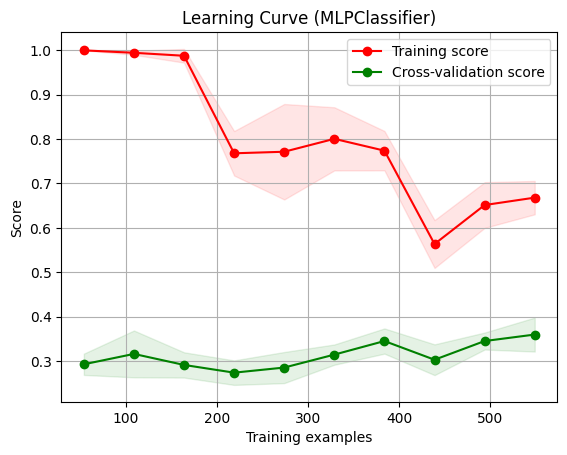

In [22]:
# Plot learning curve
train_sizes, train_scores, test_scores = learning_curve(best_model, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy')

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()
plt.title("Learning Curve (MLPClassifier)")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.legend(loc="best")
plt.show()

c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\nlp_risk_prediction\nlp_env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


            Feature  Importance       Std
5         Discovery    0.152899  0.031936
2       Error_Cause    0.077778  0.023214
9         Directive    0.074396  0.020146
7      Action_Taken    0.071256  0.025038
6   Completion_Note    0.069324  0.019234
8  Work_Description    0.066184  0.024873
3     Cause_Details    0.054831  0.025289
0             Group    0.038164  0.027430
4       Error_Class    0.031159  0.016958
1           Symptom    0.024396  0.019577


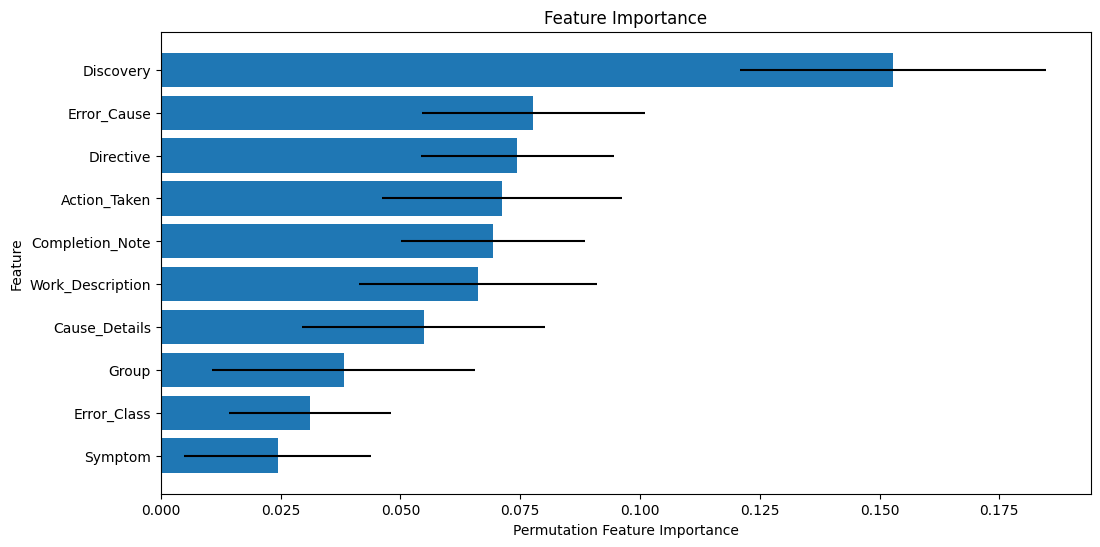

In [23]:
from sklearn.inspection import permutation_importance

# Train the best model
best_model.fit(X_train, y_train)

# Calculate permutation feature importance
perm_importance = permutation_importance(best_model, X_test, y_test, n_repeats=30, random_state=42, n_jobs=-1)

# Create a DataFrame to display feature importance
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': perm_importance.importances_mean,
    'Std': perm_importance.importances_std
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)

# Plot feature importance
plt.figure(figsize=(12, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], xerr=feature_importance_df['Std'])
plt.xlabel('Permutation Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()